In [1]:
import geopandas as gpd
from gerrychain import Graph, Partition, updaters
from gerrychain.updaters import Tally, cut_edges
import maup
import networkx as nx
from maup.smart_repair import smart_repair
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, Election
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import time
import random
import pandas
import numpy as np

In [2]:
gdf = gpd.read_file('./IN/IN.shp')

gdf = gdf.fillna(value={'ALL_TOT20': 0})
gdf = gdf.fillna(value={'VAP_TOT20': 0})
graph = Graph.from_geodataframe(gdf)

In [3]:
initial_partition = Partition(
      graph, 
      assignment="CD",
      updaters={
          "cut_edges":cut_edges, 
          "population": Tally("ALL_TOT20", alias="population"), 
          "latino population": Tally("VAP_TOT20", alias = "voting age population"), 
          "dem votes": Tally("PRES20D", alias = "dem votes"),
      }
)

In [4]:
def cut_edges_length(p):
  return len(p["cut_edges"])

# https://gerrychain.readthedocs.io/en/latest/user/recom/#a-real-world-example
compactness_bound = constraints.UpperBound(
  cut_edges_length,
  2*len(initial_partition["cut_edges"])
)

In [5]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [6]:
proposal = partial(
    recom,
    pop_col = "ALL_TOT20",
    pop_target = ideal_population,
    epsilon=0.01,
    node_repeats=2
)


In [7]:
recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=50 # significant enough time, does not take too long
)

<Axes: >

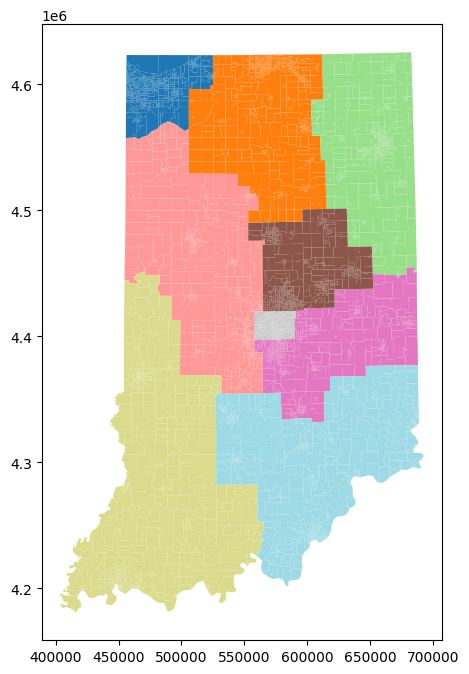

In [8]:
gdf.plot(pd.Series([initial_partition.assignment[i] for i in gdf.index]), cmap="tab20", figsize=(16,8))